In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import cv2
import numpy as np
from tqdm import tqdm


In [2]:
train = datasets.MNIST("../data/", train=True, download=True, transform = transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST("../data/", train=False, download=True, transform = transforms.Compose([transforms.ToTensor()]))

In [3]:
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=True)
IM_SIZE = 28*28
IM_SHAPE = (28, 28)

In [4]:

# Just a simple PCA, works a little bit some pictures can be red.
# EPOCH = 3, Batch = 10 and cross_entropie         => loss = 310206
# EPOCH = 10, Batch = 50 and cross_entropie        => loss = 314635
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1_en = nn.Linear(IM_SIZE, 16)
        self.fc1_de = nn.Linear(16, IM_SIZE)
        
    def forward(self, x):
        x = F.sigmoid(self.fc1_en(x))
        return F.sigmoid(self.fc1_de(x))
                
net = Net()
print(net)  


Net(
  (fc1_en): Linear(in_features=784, out_features=16, bias=True)
  (fc1_de): Linear(in_features=16, out_features=784, bias=True)
)


In [5]:

# Simple PCA weights are tied. 
# EPOCH = 10, Batch = 10 and cross_entropie        => loss = 280169
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(IM_SIZE, 16)
        
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        return F.sigmoid(F.linear(x, self.fc1.weight.transpose(0,1), bias=None))
                
net = Net()
print(net)  

Net(
  (fc1): Linear(in_features=784, out_features=16, bias=True)
)


In [12]:

# 1 hidden layer and dropout:
# EPOCH = 3, Batch = 10 and mse                    => loss = 244880
# EPOCH = 3, Batch = 10 and cross_entropie         => loss = 192187
# EPOCH = 10, Batch = 10 and cross_entropie        => loss = 171493
# EPOCH = 100, Batch = 10 and cross_entropie       => loss = 161830
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1_en = nn.Linear(IM_SIZE, 64)
        self.fc2_en = nn.Linear(64, 16)
        self.fc1_de = nn.Linear(16, 64)
        self.fc2_de = nn.Linear(64, IM_SIZE)
        self.dropout = nn.Dropout2d(0.5)
        
    def forward(self, x):
        x = self.dropout(x)
        x = F.sigmoid(self.fc1_en(x))
        x = F.sigmoid(self.fc2_en(x))
        x = F.sigmoid(self.fc1_de(x))
        return F.sigmoid(self.fc2_de(x))
                
net = Net()
print(net)  

Net(
  (fc1_en): Linear(in_features=784, out_features=64, bias=True)
  (fc2_en): Linear(in_features=64, out_features=16, bias=True)
  (fc1_de): Linear(in_features=16, out_features=64, bias=True)
  (fc2_de): Linear(in_features=64, out_features=784, bias=True)
  (dropout): Dropout2d(p=0.5, inplace=False)
)


In [7]:
# 1 hidden layer, dropout and tied weights:
# EPOCH = 10, Batch = 10 and cross_entropie        => loss = 238903
# EPOCH = 100, Batch = 10 and cross_entropie        => loss = 174692
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(IM_SIZE, 64)
        self.fc2 = nn.Linear(64, 16)
        self.dropout = nn.Dropout2d(0.5)
        
    def forward(self, x):
        x = self.dropout(x)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(F.linear(x, self.fc2.weight.transpose(0,1), bias=None))
        return F.sigmoid(F.linear(x, self.fc1.weight.transpose(0,1), bias=None))
                
net = Net()
print(net)  

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (dropout): Dropout2d(p=0.5, inplace=False)
)


In [13]:
optimizer = optim.Adam(net.parameters(), lr=0.0001)
EPOCHS = 100

for epoch in range(EPOCHS):
    for X, _ in tqdm(trainset):
        net.zero_grad()
        output = net(X.view(-1, IM_SIZE))
        loss = F.binary_cross_entropy(output, X.view(-1, IM_SIZE), reduction='sum')
        loss.backward()
        optimizer.step()
    print(epoch, loss)

  0%|          | 11/6000 [00:00<00:54, 109.57it/s]

0 tensor(2099.0764, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 12/6000 [00:00<00:55, 107.39it/s]

1 tensor(1690.7408, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 12/6000 [00:00<00:49, 119.88it/s]

2 tensor(1653.5696, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 13/6000 [00:00<00:48, 122.92it/s]

3 tensor(1687.2570, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 12/6000 [00:00<00:50, 119.17it/s]

4 tensor(1581.2070, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 10/6000 [00:00<01:02, 96.24it/s]

5 tensor(1748.1752, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 13/6000 [00:00<00:47, 126.74it/s]

6 tensor(1566.8822, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 9/6000 [00:00<01:10, 84.94it/s]

7 tensor(1682.2877, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 14/6000 [00:00<00:43, 138.16it/s]

8 tensor(1620.3513, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 14/6000 [00:00<00:46, 128.26it/s]

9 tensor(1512.4867, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 12/6000 [00:00<00:50, 119.44it/s]

10 tensor(1548.2789, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 17/6000 [00:00<00:35, 166.98it/s]

11 tensor(1343.0652, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 14/6000 [00:00<00:44, 135.07it/s]

12 tensor(1342.2495, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 16/6000 [00:00<00:38, 154.78it/s]

13 tensor(1453.3287, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 14/6000 [00:00<00:45, 132.33it/s]

14 tensor(1160.3040, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 17/6000 [00:00<00:35, 168.43it/s]

15 tensor(1419.2274, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 15/6000 [00:00<00:41, 144.50it/s]

16 tensor(1543.2853, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 16/6000 [00:00<00:37, 159.19it/s]

17 tensor(1309.2440, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 16/6000 [00:00<00:37, 158.61it/s]

18 tensor(1165.6726, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 17/6000 [00:00<00:36, 163.46it/s]

19 tensor(1336.2094, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 17/6000 [00:00<00:35, 166.69it/s]

20 tensor(1209.4725, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 23/6000 [00:00<00:26, 228.70it/s]

21 tensor(1136.9316, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 174.14it/s]

22 tensor(1185.7837, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 172.07it/s]

23 tensor(1059.9203, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 173.74it/s]

24 tensor(1294.6923, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 24/6000 [00:00<00:25, 232.59it/s]

25 tensor(1332.8191, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 23/6000 [00:00<00:26, 228.36it/s]

26 tensor(1111.6042, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 23/6000 [00:00<00:26, 228.36it/s]

27 tensor(1241.7365, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 23/6000 [00:00<00:26, 229.05it/s]

28 tensor(888.5555, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 24/6000 [00:00<00:25, 232.27it/s]

29 tensor(1024.1543, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 24/6000 [00:00<00:26, 228.01it/s]

30 tensor(1046.0365, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 24/6000 [00:00<00:25, 230.90it/s]

31 tensor(1247.2681, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 172.25it/s]

32 tensor(1093.0181, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 174.57it/s]

33 tensor(1298.4967, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 173.30it/s]

34 tensor(1049.9567, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 172.38it/s]

35 tensor(1036.4293, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 171.88it/s]

36 tensor(1009.2084, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 171.59it/s]

37 tensor(1034.0769, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 175.50it/s]

38 tensor(1163.3922, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 175.23it/s]

39 tensor(1139.5796, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 172.23it/s]

40 tensor(1104.6091, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 174.56it/s]

41 tensor(1276.1681, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 174.16it/s]

42 tensor(1383.0645, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 14/6000 [00:00<00:43, 137.84it/s]

43 tensor(1124.5154, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 16/6000 [00:00<00:38, 155.28it/s]

44 tensor(1154.5873, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 16/6000 [00:00<00:39, 153.07it/s]

45 tensor(1080.5594, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 15/6000 [00:00<00:40, 148.88it/s]

46 tensor(1187.2616, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 20/6000 [00:00<00:30, 193.01it/s]

47 tensor(986.2787, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 173.50it/s]

48 tensor(1129.4473, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:33, 176.09it/s]

49 tensor(1062.6271, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 20/6000 [00:00<00:30, 194.90it/s]

50 tensor(1257.4208, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 16/6000 [00:00<00:37, 157.95it/s]

51 tensor(1267.7484, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:33, 178.41it/s]

52 tensor(1112.4777, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 24/6000 [00:00<00:25, 230.99it/s]

53 tensor(915.1042, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 24/6000 [00:00<00:25, 231.46it/s]

54 tensor(922.0525, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 24/6000 [00:00<00:25, 231.43it/s]

55 tensor(1053.1436, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 23/6000 [00:00<00:25, 229.95it/s]

56 tensor(1019.2628, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 173.74it/s]

57 tensor(956.0283, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 172.04it/s]

58 tensor(1034.9341, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 174.23it/s]

59 tensor(1111.9946, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 172.00it/s]

60 tensor(1209.5326, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 172.74it/s]

61 tensor(1091.2947, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 172.66it/s]

62 tensor(1046.8107, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 172.19it/s]

63 tensor(969.9122, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 171.72it/s]

64 tensor(1132.3134, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 174.02it/s]

65 tensor(1009.7790, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 171.44it/s]

66 tensor(952.8062, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 171.85it/s]

67 tensor(1115.5962, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 171.73it/s]

68 tensor(978.4135, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:35, 170.81it/s]

69 tensor(1109.3575, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 24/6000 [00:00<00:25, 233.78it/s]

70 tensor(1162.4537, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 171.40it/s]

71 tensor(1247.0383, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 174.33it/s]

72 tensor(1137.3649, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 173.11it/s]

73 tensor(902.0557, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:35, 170.84it/s]

74 tensor(980.1539, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 174.23it/s]

75 tensor(1042.0798, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 24/6000 [00:00<00:25, 231.45it/s]

76 tensor(873.3672, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 171.78it/s]

77 tensor(932.0964, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 174.70it/s]

78 tensor(1135.4348, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 175.10it/s]

79 tensor(1041.8335, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 172.27it/s]

80 tensor(1044.0165, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 24/6000 [00:00<00:25, 234.03it/s]

81 tensor(1032.4995, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 24/6000 [00:00<00:25, 231.90it/s]

82 tensor(813.3052, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 175.37it/s]

83 tensor(1133.9181, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 171.09it/s]

84 tensor(905.0473, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 172.85it/s]

85 tensor(1079.8579, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 173.70it/s]

86 tensor(899.1992, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 17/6000 [00:00<00:35, 167.52it/s]

87 tensor(1124.6122, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:35, 170.78it/s]

88 tensor(1148.2618, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 171.01it/s]

89 tensor(889.4936, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 175.30it/s]

90 tensor(943.7249, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 24/6000 [00:00<00:25, 234.27it/s]

91 tensor(1074.6777, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 174.27it/s]

92 tensor(1146.2902, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 172.14it/s]

93 tensor(1070.6221, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 174.72it/s]

94 tensor(928.3834, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 175.37it/s]

95 tensor(1084.6295, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 173.48it/s]

96 tensor(894.4249, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 172.35it/s]

97 tensor(804.5303, grad_fn=<BinaryCrossEntropyBackward>)


  0%|          | 18/6000 [00:00<00:34, 174.36it/s]

98 tensor(1092.9518, grad_fn=<BinaryCrossEntropyBackward>)


100%|██████████| 6000/6000 [00:33<00:00, 177.62it/s]

99 tensor(940.3210, grad_fn=<BinaryCrossEntropyBackward>)


100%|██████████| 1000/1000 [00:01<00:00, 563.99it/s]


tensor(161830.7969)


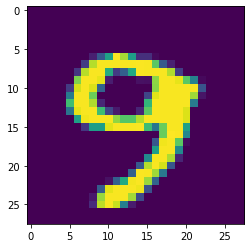

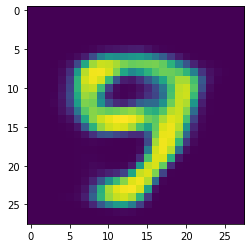

In [16]:
loss = 0
with torch.no_grad():
    for X, _ in tqdm(testset):
        output = net(X.view(-1, IM_SIZE))
        loss += F.mse_loss(output, X.view(-1, IM_SIZE), reduction='sum')

print(loss)
plt.imshow(X[0].view(IM_SHAPE))
plt.show()
plt.imshow(output[0].view(IM_SHAPE))
plt.show()


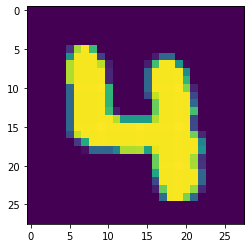

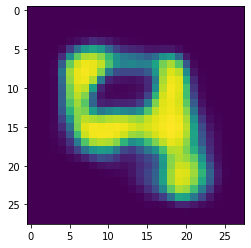

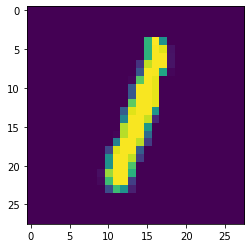

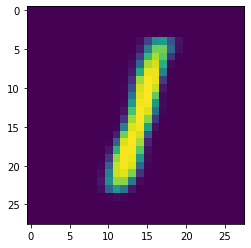

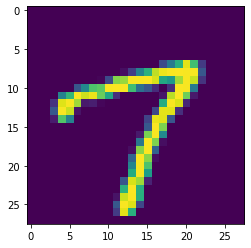

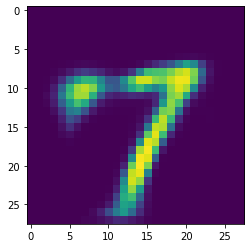

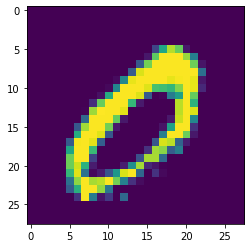

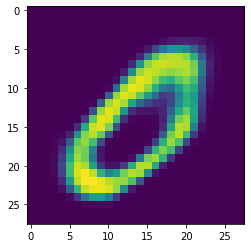

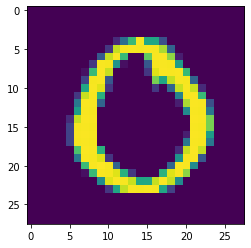

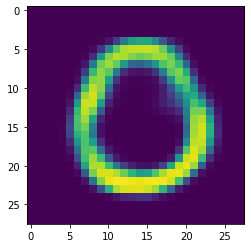

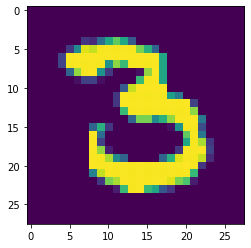

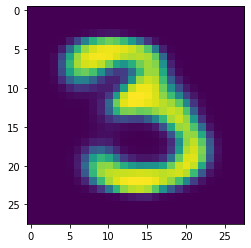

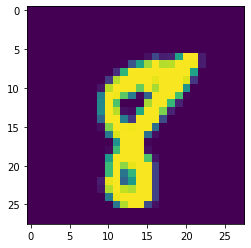

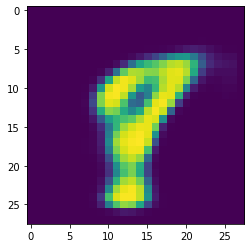

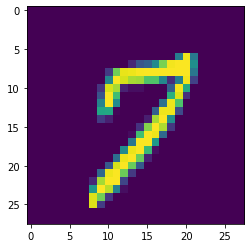

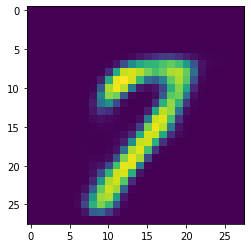

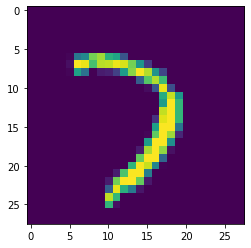

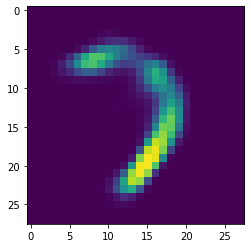

In [17]:
for i in range(1,10):
    plt.imshow(X[i].view(IM_SHAPE))
    plt.show()
    plt.imshow(output[i].view(IM_SHAPE))
    plt.show()
